# Description of notebook

This notebook includes the code for the solution to task 5: Bayesian Neural Network.

In [1]:
%matplotlib inline

# Standard packages
import os
import time
import pickle
from multiprocessing import Pool as ThreadPool
import sys

# Third party packes
import emcee
import corner
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tqdm import tqdm_notebook as tqdm

# Custom imports
from lattice import Lattice

# Set numpy seed
np.random.seed(42)

# Set plot params
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

### Code for generating data - from project description

In [2]:
# 10 x 10 lattice
# 60 temperatures, 500 thermalization iterations

# For a temperature range, thermalize a lattice, then
# take a few hundred steps, recording energy and magnetization.
# Store the means to plot next.
# This takes about 60s with one modern core.

# Thermalization and measurement steps
ntherm = 500
nmeasure = 200

# points = array with (T, mean(E), abs(mean(M)), var(E))
# with the mean and variance evaluated for a list of many temperatures
points = []
# Storing nmeasure / nsparse data points
nsparse = 10
# points_full = array with (T, E, abs(M))
# for several different configurations per temperature
points_full=[]
for T in tqdm(np.arange(4.0,1.0,-0.05)):
    lat = Lattice(N=10,T=T)
    for _ in range(ntherm):
        lat.step()
    Es = []
    Ms = []

    for istep in range(nmeasure): 
        lat.step()
        Es.append(lat.get_energy())
        Ms.append(lat.get_avg_magnetization())
        if (istep%nsparse==0):
            points_full.append((T,Es[-1],np.abs(Ms[-1])))           
    Es = np.array(Es)
    Ms = np.array(Ms)
    points.append((T,Es.mean(),np.abs(Ms.mean()),Es.var()))
points = np.array(points)
points_full = np.array(points_full)

In [3]:
# Calculate critical temperature
Tc = 2 / np.log(1+np.sqrt(2))
print(f"Critical temperature: Tc = {Tc:.4f}")

Critical temperature: Tc = 2.2692


### Prepare data for BNN

Prepare the data for the BNN by only using low and high temperature data and normalizing it.

In [4]:
# Normalize data. Remove mean and divide with standard deviation
def normalize(train_data, test_data):
    '''
    Normalize train_data and test_data using the mean and standard deviation from the 
    train_data set. This is as to not contaminate the test_data and introduce correlations. 
    '''
    # Iterate over all columns in training data, and normalize all data using training data!
    mean_save = np.zeros(2) # To save for renormalization in model evaluation (See contour plot)
    std_save = np.zeros(2)
    for i in range(1,2+1):
        # We want to normalize columns 1 and 2 - not T, will be one-hot encoded!
        mean = train_data[:,i].mean(axis=0)
        std = train_data[:,i].std(axis=0)
        assert (std-0) > 1e-5  # Check so standard deviation is not zero!
        train_data[:,i] -= mean
        train_data[:,i] /= std
        test_data[:,i] -= mean
        test_data[:,i] /= std
        mean_save[i-1] = mean
        std_save[i-1] = std
    return train_data, test_data, mean_save, std_save


def data_split(data, train_fraction, seed, shuffle):
    '''Shuffle the dataset, and then split into two fractions'''
    if shuffle:
        np.random.shuffle(data)  # Shuffles along the first dimension, i.e. along the row dimension. 
    # Split into two parts, with the train_set being train_frac
    split_idx = int(data.shape[0]*train_fraction)
    test_data = data[:split_idx]
    train_data = data[split_idx:]
    return train_data, test_data


def one_hot_labels(data, Tc):
    '''One hot encodes the first column in data. Use boolean expressions.'''
    bool_arr = data[:,0] > Tc
    data[:,0] = bool_arr
    return data
    
    
def prepare_data(full_data, Tc, test_fraction=0.3, seed=1, shuffle=True, low_high_T=False, Tlo = 1.5, Thi = 3.5):
    '''
    One-hot encodes T-column as 0 if T < Tc and 1 if T > Tc.  
    Shuffles and splits the dataset into a training and a test set. 
    Finally normalizes the test and train sets using the train set.
    '''
    np.random.seed(seed)
    data = np.copy(full_data) # Make a copy, as not to overwrite original data
    if low_high_T:
        # Only pick out the datarows at the edges of the temperature range
        idx_hi = data[:,0] >= Thi 
        idx_lo = data[:,0] <= Tlo
        idx = idx_hi + idx_lo
        data =  data[idx]
    data = one_hot_labels(data, Tc)  # One-hot encode labels
    train_data, test_data = data_split(data, test_fraction, seed, shuffle)  # Shuffle and split the dataset
    train_data, test_data, mean, std = normalize(train_data, test_data)
    
    return train_data, test_data, mean, std
    
train_data, test_data, mean, std = prepare_data(points_full, Tc, 0.3, seed=1, low_high_T=True)
print(train_data.shape)
print(test_data.shape)

(280, 3)
(120, 3)


### Define the BNN

We are interested in $p(y^{N+1}|x^{N+1}, D)$. Using marginalization, the product rule and Baye's theorem, we can write this as: 

$$ p(y^{N+1}|x^{N+1}, D) = \int_W dW p(y^{N+1}|x^{N+1}, D, W) p(W|D).$$

$p(y^{N+1}|x^{N+1}, D, W)$  is often approximated as $y(x^{N+1}; W)$ (?) since that is really no pdf for a fix value of $W$. $p(W|D)$ is given as:

$$ p(W|D) \propto p(D|W) p(W),$$

which is the likelihood for our data and our prior for our weights $ W $ respectively. Thus we have, in total: 

$$ p(y^{N+1}|x^{N+1}, D) \propto \int_W dW y(x^{N+1}; W) p(D|W) p(W),$$

where we can sample the integral using MCMC sampling over our $W$-space.

Now define priors for our weights and bias, which we are assume to be independent, as well as our log likelihood, log posterior and feed forward pass (from Task 1). 

In [5]:
# Define prior for W and b
def log_prior(W, sigma=1.0):
    '''
    Gaussian prior centered around 0 for weights W (including bias b=W[0]). The total 
    prior is the product of the priors for b, W0 and W1, all with the same sigma. 
    '''
    return -W.shape[0]/2*np.log(2*np.pi*sigma**2) - (W.dot(W))/sigma**2


# TODO Define likelihood for data D given W
def log_likelihood(W, t, x):
    '''Log-binary crossentropy'''
    y = feed_forward(x, W[1:], W[0])
    
    return np.sum(t*np.log(y) + (1-t)*np.log(1-y))


def feed_forward(x, W, b):
    '''Performs the feed-forward pass for our neuron. Return the activation.'''
    a = x@W + b
    
    return sigmoid(a)  


def sigmoid(a):
    '''¨Returns the sigmoid value of the activation a.'''
    return 1/(1+np.exp(-a))


def log_posterior(W, t, x, sigma):
    '''Returns the log posterior, given weights W, targets t, training data t and weight decay sigma.'''
    return log_prior(W, sigma) + log_likelihood(W, t, x)

### Sample the weight space with emcee

Use ten walkers to sample the three weight and bias dimensions. This cell takes a few seconds to execute.

In [6]:
# Define sampling properties
ndim = 3
nwalkers = 10
W0 = np.random.randn(nwalkers, ndim)
nburn = 200
nsamples = 10000

# Additional arguments for the sampler e.g. target and training data
argtuple = (train_data[:,0], train_data[:,1:], 1)  # targets, input data, sigma

# Define sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=argtuple)

# Perform the sampling
t0 = time.time()
sampler.run_mcmc(W0, nburn+nsamples)
t1 = time.time()
print(f'Time for sample: {(t1-t0):.1f} seconds')

# Extract the samples and ignore the burn-in
samples = sampler.chain[:, nburn:, :].reshape(-1, ndim)

Time for sample: 11.4 seconds


### Extract weights and bias pdf:s for the BNN

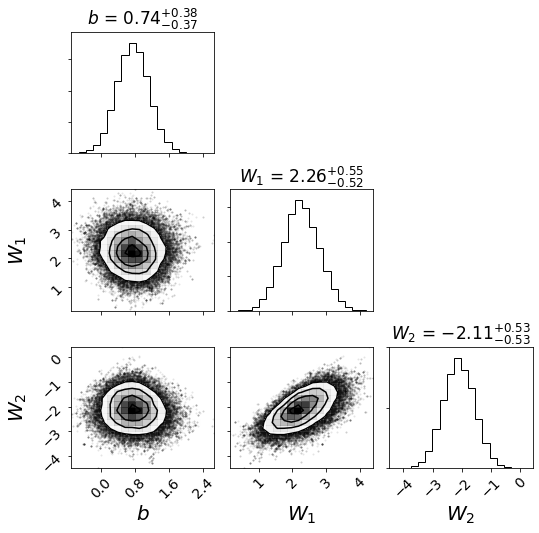

In [7]:
# Plot the weights with corner
fig_weights = corner.corner(samples, labels=[r'$b$', r'$W_1$', r'$W_2$'], label_kwargs={'fontsize': 20},
                            show_titles=True, title_kwargs={'fontsize': 17})
plt.tight_layout()
plt.savefig('corner_bnn.png')

### Predict for high, low and near critical temperatures using the BNN

Plot the predictions over all our sampled models as histograms. Do this for high, low and near critical temperature data. 

In [8]:
# Extract all weights and biases for all of our models
bias = samples[:,0].reshape(1,-1) # Apply transpose to achieve correct shape for feed forward
weights = samples[:,1:].T
x_train = test_data[:,1:]
y_pred = feed_forward(x_train, weights, bias)

In [9]:
# Set plot params for these graphs specifically
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

High temperature: 4.00 K.
Low temperature: 1.05 K.
Close to critical temperature: 2.25 K.


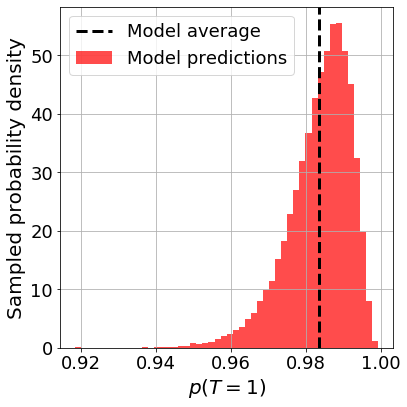

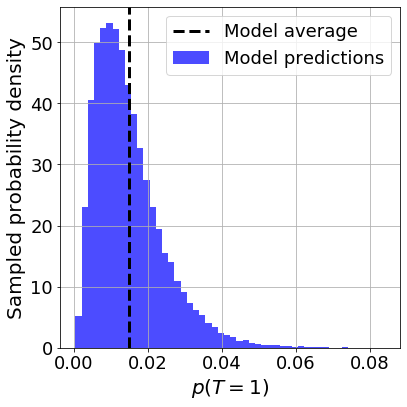

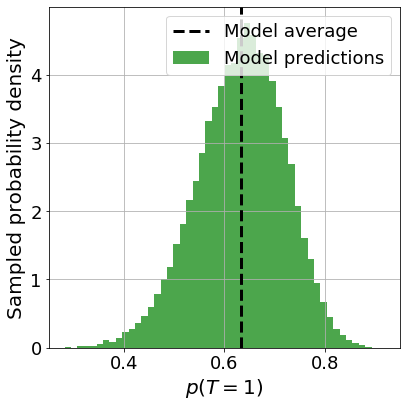

In [10]:
# Histogram over all models for one sample datapoint
high_T_p = points_full[points_full[:,0] > 3.5][0]
low_T_p = points_full[points_full[:,0] < 1.5][-1]
critical_T_p = points_full[np.abs(points_full[:,0] - Tc) < 0.02][0]

print(f'High temperature: {high_T_p[0]:.2f} K.')
print(f'Low temperature: {low_T_p[0]:.2f} K.')
print(f'Close to critical temperature: {critical_T_p[0]:.2f} K.')

# Normalize
high_T_norm = np.array((high_T_p[1:] - mean)/std).reshape(1,-1)
low_T_norm = (low_T_p[1:] - mean)/std
critical_T_norm = (critical_T_p[1:] - mean)/std



# High temperaure
y_high = feed_forward(high_T_norm, weights, bias)


fig, ax1 = plt.subplots(figsize=(6,6))
ax1.hist(y_high[0], bins=50, color='r' ,alpha=0.7, label='Model predictions', density=True)
ax1.axvline(y_high.mean(), c='k', linestyle='--', linewidth=3, label='Model average')
ax1.set_xlabel(r'$p(T=1)$')
ax1.set_ylabel('Sampled probability density')
ax1.legend(loc='best')
ax1.grid()
plt.tight_layout()
plt.savefig('predict_high_T.png')


# Low temperature
y_low = feed_forward(low_T_norm, weights, bias)

fig, ax2 = plt.subplots(figsize=(6,6))
ax2.hist(y_low[0], bins=50, color='b', alpha=0.7, label='Model predictions', density=True)
ax2.axvline(y_low.mean(), c='k', linestyle='--', linewidth=3, label='Model average')
ax2.set_xlabel(r'$p(T=1)$')
ax2.set_ylabel('Sampled probability density')
ax2.legend(loc='best')
ax2.grid()
plt.tight_layout()
plt.savefig('predict_low_T.png')

# Close to critical temperature
y_crit = feed_forward(critical_T_norm, weights, bias)
fig, ax3 = plt.subplots(figsize=(6,6))
ax3.hist(y_crit[0], bins=50, color='g', alpha=0.7, label='Model predictions', density=True)
ax3.axvline(y_crit.mean(), c='k', linestyle='--', linewidth=3, label='Model average')
ax3.set_xlabel(r'$p(T=1)$')
ax3.set_ylabel('Sampled probability density')
ax3.legend(loc='best')
ax3.grid()
plt.tight_layout()
plt.savefig('predict_crit_T.png')


In [11]:
# Revert back to original plot settings
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

### Extra: Generate contour plots for mean prediction and uncertainty as measured by standard deviation

Mean and standard deviation are computed over all our sampled models, evaluated on a $E$, $m$ grid. The contours descibes the output of the BNN in a bit more detail. 

In [12]:
# Define endpoints of grid
E_max = points_full[:,1].max()
E_min = points_full[:,1].min()
m_max = points_full[:,2].max()
m_min = points_full[:,2].min()

# Define grid
step_E = 2
step_m = 0.01
E = np.arange(E_min, E_max+step_E, step_E)
m = np.arange(m_min, m_max+step_m, step_m)

# Normalize data with same mean and std as for training data
E_norm = (E - mean[0]) / std[0]
m_norm = (m - mean[1]) / std[1]

# Calculate predictions. Apply for-loops for simplicity due to low number of samples
pred_mean = np.zeros((m_norm.shape[0], E_norm.shape[0]))
pred_std = np.zeros((m_norm.shape[0], E_norm.shape[0]))
for i, En in enumerate(tqdm(E_norm)):
    for j, mn in enumerate(m_norm):
        x = np.array([En, mn]).reshape(1,2)
        y = feed_forward(x, weights, bias)
        pred_mean[j,i] = np.mean(y, axis=1)
        pred_std[j,i] = np.std(y, axis=1)

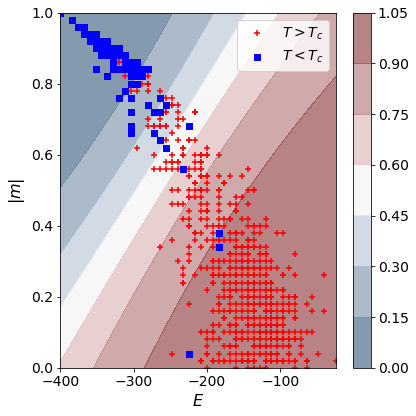

In [13]:
# Plot the mean contour
high_T = points_full[:,0]>Tc
low_T = points_full[:,0]<Tc
E_M_high = points_full[high_T][:,1:]
E_M_low = points_full[low_T][:,1:]

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(6,6))
contour = ax.contourf(E, m, pred_mean, cmap=cmap, alpha=0.6)
ax.scatter(E_M_high[:,0],E_M_high[:,1],c='r', marker='+', label=r'$T>T_c$')
ax.scatter(E_M_low[:,0],E_M_low[:,1],c='b', marker='s', label=r'$T<T_c$')

# Figure properties
cbar = plt.colorbar(contour, ax=ax)
ax.set_xlim(E_min, E_max)
ax.set_ylim(m_min, m_max)
ax.set_xlabel("$E$")
ax.set_ylabel("$|m|$")
ax.legend(loc='best')
plt.tight_layout()
plt.savefig('bnn_contour_mean.png')
plt.show()

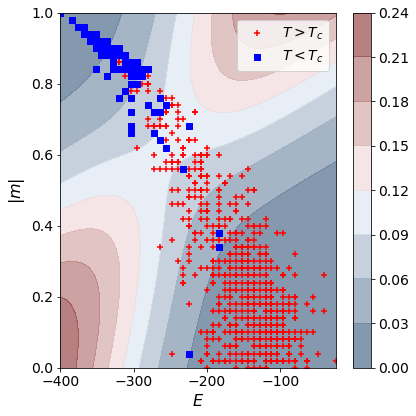

In [14]:
# Plot the standard deviation contour
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(6,6))
contour = ax.contourf(E, m, pred_std, cmap=cmap, alpha=0.6)
ax.scatter(E_M_high[:,0],E_M_high[:,1], c='r',  marker='+', label=r'$T>T_c$')
ax.scatter(E_M_low[:,0],E_M_low[:,1], c='b', marker='s', label=r'$T<T_c$')

# Figure properties
cbar = plt.colorbar(contour, ax=ax)
ax.set_xlim(E_min, E_max)
ax.set_ylim(m_min, m_max)
ax.set_xlabel("$E$")
ax.set_ylabel("$|m|$")
ax.legend(loc='best')
plt.tight_layout()
plt.savefig('bnn_contour_std.png')
plt.show()